In [1]:
import os
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [2]:
class ScriptData:
    """
    Represents a set of stock data.

    Attributes:
        data (dict): A dictionary of stock data.
    """

    def __init__(self):
        self.data = {}

    def add_data(self, key, value):
        """
        Adds data to the dictionary.

        Args:
            key (str): The key for the data.
            value (pd.DataFrame): The data.
        """
        self.data[key] = value

    def get_data(self, key):
        """
        Gets data from the dictionary.

        Args:
            key (str): The key for the data.

        Returns:
            pd.DataFrame: The data.
        """
        if key in self.data.keys():
            return self.data[key]
        return "Data does not exist"

    def fetch_intraday_data(self, symbol):
        """
        Fetches intraday data for the given symbol.

        Args:
            symbol (str): The symbol of the stock.

        Returns:
            pd.DataFrame: The intraday data.
        """
        response = requests.get(f"https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval=5min&apikey={os.environ['US_Stocks_Key']}")
        if response.status_code == 200:
            print("Successfully fetched the data")
            self.add_data(symbol, response.json()["Time Series (5min)"])
        else:
            print(f"There was a {response.status_code} error with your request")

    def convert_intraday_data(self, symbol):
        """
        Converts intraday data to a DataFrame.

        Args:
            symbol (str): The symbol of the stock.

        Returns:
            pd.DataFrame: The converted intraday data.
        """
        data2 = []
        for k, v in self.data[symbol].items():
            lst = []
            lst.append(k)
            for i in v.values():
                lst.append(i)
            data2.append(lst)
        data2.reverse()
        df = pd.DataFrame(data2, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.astype({'open': float, 'high': float, 'low': float, 'close': float, 'volume': int})
        self.add_data(symbol, df)

In [3]:
def indicator1(df, timeperiod):
    """
    Calculates the moving average of the close prices over a given time period.

    Args:
        df (pd.DataFrame): The DataFrame containing the close prices.
        timeperiod (int): The number of periods to use for the moving average.

    Returns:
        pd.DataFrame: The DataFrame containing the moving average.
    """

    df2 = pd.DataFrame(columns=['timestamp', 'indicator'])
    df2['timestamp'] = df['timestamp']
    for index, row in df.iterrows():
        if index >= timeperiod - 1:
            value = (df.loc[index - timeperiod + 1:index, 'close'].sum()) / timeperiod
            df2.loc[index:index + 1, 'indicator'] = value
    return df2

In [4]:
class Strategy(ScriptData):
    """
    Represents a trading strategy.

    Attributes:
        symbol (str): The symbol of the stock.
    """

    def __init__(self, symbol):
        """
        Initializes a new Strategy object.

        Args:
            symbol (str): The symbol of the stock.
        """
        super().__init__()
        self.symbol = symbol

    def get_script_data(self):
        """
        Fetches the intraday data for the stock.
        """
        self.fetch_intraday_data(self.symbol)
        self.convert_intraday_data(self.symbol)

    def get_signals(self):
        """
        Gets the list of buy and sell signals.

        Returns:
            pd.DataFrame: The list of buy and sell signals.
        """
        # Initialize signals
        signals = []
        for i in range(4):
            signals.append('NO SIGNAL')

        # Fetch data
        df = self.get_data(self.symbol)
        
        # Fetch the close prices
        close_prices = df['close']

        # Fetch the moving average
        moving_average = indicator1(df, 5)['indicator']

        # Loop over the close prices
        for i in range(len(close_prices)):
            if i >= 4:
                # If the close price is greater than the moving average,
                # then set the buy signal to True
                if close_prices[i] > moving_average[i]:
                    signals.append('BUY')

                # If the close price is less than the moving average,
                # then set the sell signal to True
                elif close_prices[i] < moving_average[i]:
                    signals.append('SELL')

                # Otherwise, set both signals to False
                else:
                    signals.append('NO SIGNAL')

        self.signals = pd.DataFrame()
        self.signals['timestamp'] = df['timestamp']
        self.signals['signal'] = signals

        # Remove any rows where the signal is NO SIGNAL
        self.signals = self.signals[self.signals['signal'] != 'NO SIGNAL']

        return self.signals

    def plot_graph(self):
        """
        Plots the graph of the stock data.
        """
        df = self.get_data(self.symbol)
        df2 = indicator1(df, 5)
        x = df2['timestamp'].astype('str')
        plt.figure(figsize=(30, 8))
        plt.plot(x, df['close'], label='Close', color='red', linewidth = 2)
        plt.plot(x, df2['indicator'], label="SMA", color='gray', linewidth = 2)
        plt.xticks(rotation=90)
        plt.legend(fontsize = 20)
        plt.show()

In [5]:
# Fetching data of APPLE Stocks using ScriptData class

script_data = ScriptData()
script_data.fetch_intraday_data('AAPL')
script_data.convert_intraday_data('AAPL')
df = script_data.get_data('AAPL')
df

Successfully fetched the data


,timestamp,open,high,low,close,volume
0,2023-06-16 11:15:00,186.050,186.060,185.8699,185.87,390508
1,2023-06-16 11:20:00,185.865,185.920,185.5400,185.68,466449
2,2023-06-16 11:25:00,185.690,185.780,185.3400,185.48,495189
3,2023-06-16 11:30:00,185.480,185.605,185.3800,185.42,481608
4,2023-06-16 11:35:00,185.415,185.565,185.3000,185.52,415376
...,...,...,...,...,...,...
95,2023-06-16 19:35:00,185.000,185.000,185.0000,185.00,822
96,2023-06-16 19:40:00,184.980,185.000,184.9800,184.99,1121
97,2023-06-16 19:45:00,185.000,185.000,184.9900,184.99,2045
98,2023-06-16 19:50:00,184.990,184.990,184.9900,184.99,333


In [6]:
# Fetching data of APPLE Stocks using Strategy class and also generating BUY and SELL signals

strategy = Strategy('NVDA')
strategy.get_script_data()
signals = strategy.get_signals()
signals

Successfully fetched the data


,timestamp,signal
4,2023-06-16 12:00:00,BUY
5,2023-06-16 12:05:00,BUY
6,2023-06-16 12:10:00,BUY
7,2023-06-16 12:15:00,BUY
8,2023-06-16 12:20:00,BUY
...,...,...
95,2023-06-16 19:35:00,SELL
96,2023-06-16 19:40:00,SELL
97,2023-06-16 19:45:00,BUY
98,2023-06-16 19:50:00,BUY


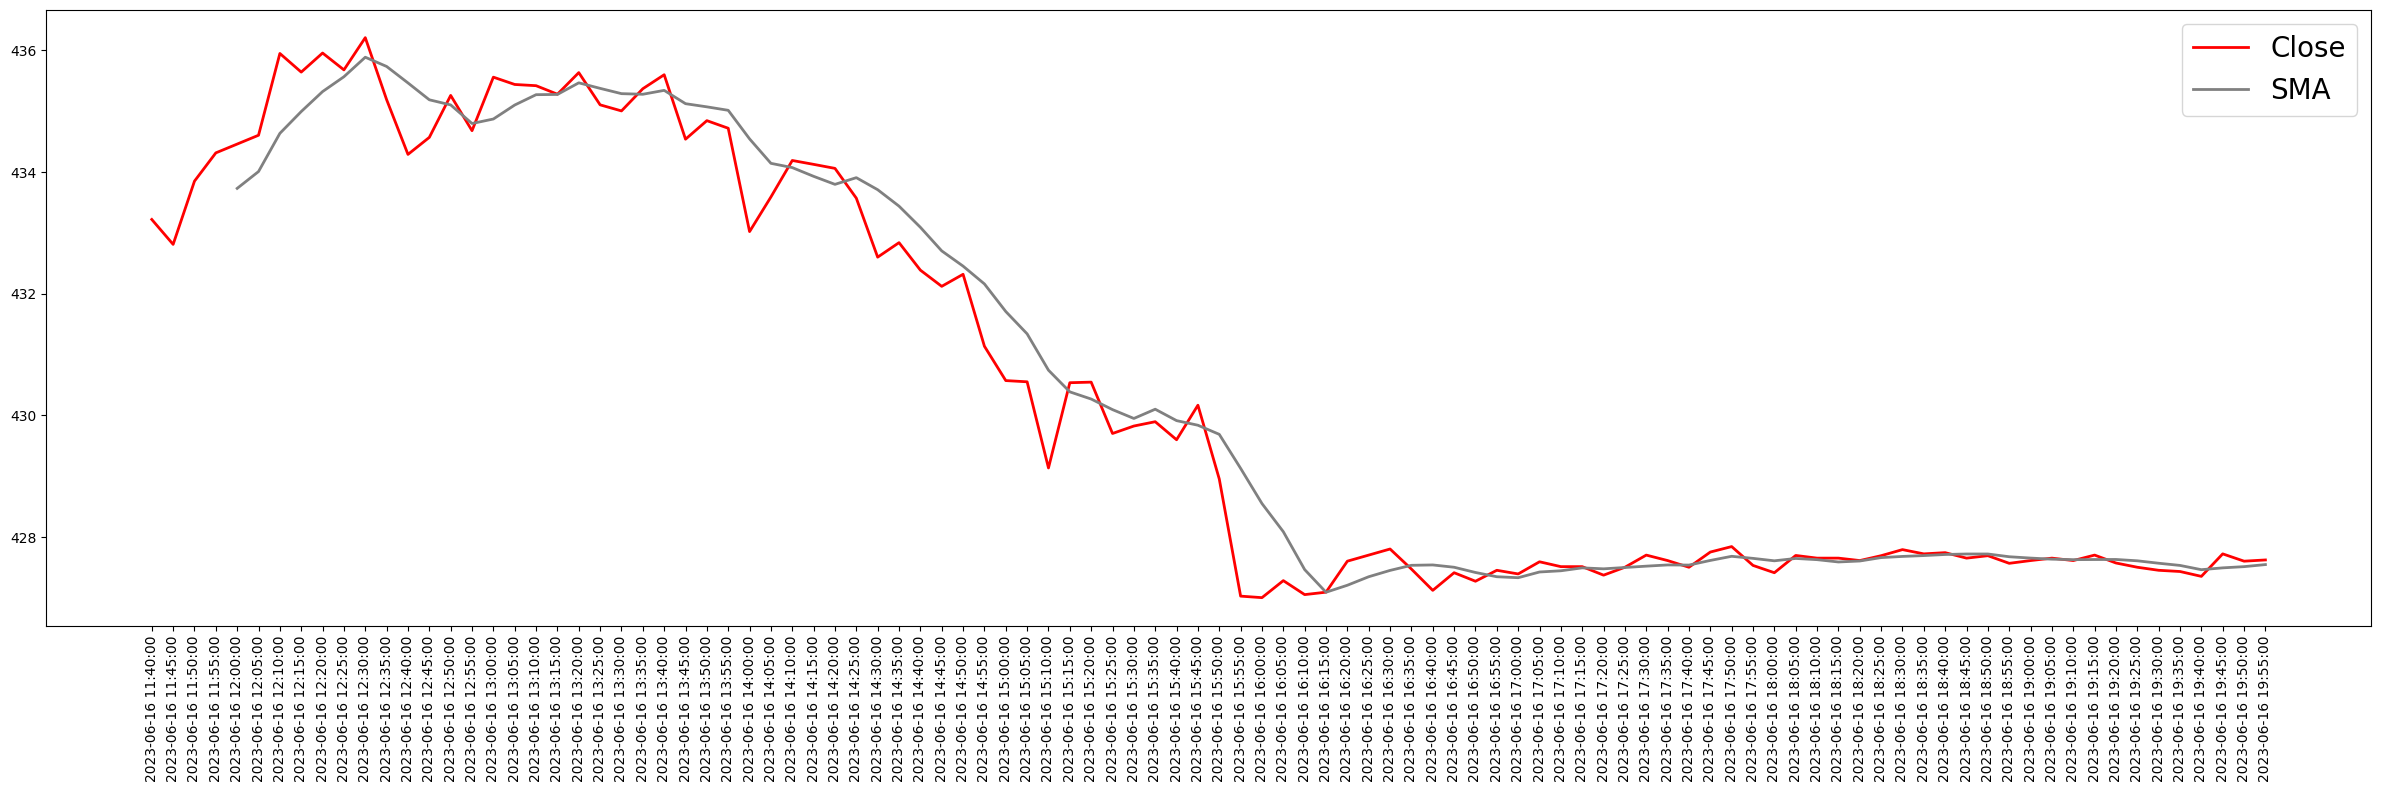

In [7]:
# Plotting a graph of Closed price and SMA using plot_graph() function defined in the Strategy class

strategy.plot_graph()